# Chapter 7.4 — Symmetry and Definiteness (Programming Set: 2, 4, 7)

**Tasks**
- **Exercise 2**: Build canonical test matrices (Pei, Hilbert, Dingdong, Lehmer, Fiedler) and classify (positive/negative definite, semidefinite, or indefinite) with numerical evidence (eigenvalue extrema and sign counts).
- **Exercise 4**: Sample the Rayleigh quotient \(R_A(x)=\frac{x^\top A x}{x^\top x}\) for a given symmetric \(A\); visualize the samples and infer the field of values.
- **Exercise 7**: Compare timings for `eigvals(A)` (general) vs `eigvalsh(S)` (symmetric) across sizes; plot runtime vs size (log–log).

---


In [1]:
# If running in a clean environment, uncomment:
# %pip install numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
import time

np.set_printoptions(precision=6, suppress=True)
rng = np.random.default_rng(7)  # reproducible


## Exercise 2 — Definiteness classification

We implement Python equivalents of classical test matrices (akin to MATLAB `gallery` or Julia `MatrixDepot`) and classify definiteness using eigenvalues.

**Matrix generators**
- **Pei**: \( P(\alpha) = \alpha I + \mathbf{1}\mathbf{1}^\top \) (here we’ll use \( \alpha=1 \)).  
- **Hilbert**: \( H_{ij} = 1/(i+j-1) \) (1-based indexing).  
- **Dingdong** (symmetric): with 1-based indices \(D_{ij} = \dfrac{1}{2\,(N-i-j+\tfrac{3}{2})}\).  
- **Lehmer**: \( L_{ij} = \min(i,j)/\max(i,j) \).  
- **Fiedler**: \( F_{ij} = |x_i - x_j| \) (default \(x_i=i\)).

We then report: min/max eigenvalues and the counts of positive/negative/zero eigenvalues.


In [2]:
def pei(n, alpha=1.0):
    I = np.eye(n)
    J = np.ones((n, n))
    return alpha * I + J

def hilb(n):
    i = np.arange(n)[:, None]
    j = np.arange(n)[None, :]
    return 1.0 / (i + j + 1.0)

def dingdong(n):
    # 1-based definition: A(i,j) = 1 / ( 2*(N - i - j + 3/2) )
    # Convert to 0-based indices for NumPy
    i = np.arange(n)[:, None]
    j = np.arange(n)[None, :]
    denom = (2*n) - 2*i - 2*j - 1  # equals 2*(N - i - j + 1.5) in 0-based
    return 1.0 / denom

def lehmer(n):
    i = np.arange(1, n+1)[:, None]
    j = np.arange(1, n+1)[None, :]
    return np.minimum(i, j) / np.maximum(i, j)

def fiedler(n, x=None):
    if x is None:
        x = np.arange(1, n+1)
    x = np.asarray(x).reshape(-1, 1)
    return np.abs(x - x.T)

def classify_definiteness(A, tol=1e-10):
    # Return (label, eigmin, eigmax, (pos,neg,zero)) for Hermitian A.
    w = np.linalg.eigvalsh(A)
    pos = np.count_nonzero(w > tol)
    neg = np.count_nonzero(w < -tol)
    zero = A.shape[0] - pos - neg
    if pos>0 and neg>0:
        label = "indefinite"
    elif pos>0 and neg==0 and zero==0:
        label = "positive definite"
    elif pos==0 and neg>0 and zero==0:
        label = "negative definite"
    elif pos>0 and neg==0 and zero>0:
        label = "positive semidefinite"
    elif pos==0 and neg>0 and zero>0:
        label = "negative semidefinite"
    else:
        label = "singular / inconclusive"
    return label, float(w.min()), float(w.max()), (int(pos), int(neg), int(zero))


In [3]:
cases = {}

# (a) Pei(5) - 6I  -> (I + J) - 6I = J - 5I
cases['(a) Pei(5) - 6I'] = pei(5) - 6*np.eye(5)

# (b) Hilb(8) - 2I
cases['(b) Hilb(8) - 2I'] = hilb(8) - 2*np.eye(8)

# (c) Dingdong(20)
cases['(c) Dingdong(20)'] = dingdong(20)

# (d) Lehmer(100)
cases['(d) Lehmer(100)'] = lehmer(100)

# (e) Fiedler(200)
cases['(e) Fiedler(200)'] = fiedler(200)

print("Classification (label, eigmin, eigmax, (pos,neg,zero)):\n")
for name, A in cases.items():
    label, emin, emax, counts = classify_definiteness(A)
    print(f"{name:>22s}: {label:>24s} | eigmin={emin:.6g}, eigmax={emax:.6g}, counts={counts}")


Classification (label, eigmin, eigmax, (pos,neg,zero)):

       (a) Pei(5) - 6I:    negative semidefinite | eigmin=-5, eigmax=6.66134e-16, counts=(0, 4, 1)
      (b) Hilb(8) - 2I:        negative definite | eigmin=-2, eigmax=-0.304061, counts=(0, 8, 0)
      (c) Dingdong(20):               indefinite | eigmin=-1.5708, eigmax=1.5708, counts=(10, 10, 0)
       (d) Lehmer(100):        positive definite | eigmin=0.00533345, eigmax=54.7649, counts=(100, 0, 0)
      (e) Fiedler(200):               indefinite | eigmin=-8105.86, eigmax=13895.9, counts=(1, 199, 0)


**Notes**
- `Pei(5)-6I = J-5I` has spectrum \(\{0,-5,\ldots,-5\}\) → negative semidefinite.
- Hilbert is SPD; shifting by \(-2I\) yields negative definite.
- Dingdong matrix has both positive and negative eigenvalues (indefinite).
- Lehmer is SPD.
- Fiedler (with \(x_i=i\)) typically has one dominant positive eigenvalue and the rest negative → indefinite.


## Exercise 4 — Field of values via Rayleigh samples

For symmetric \(A\), the field of values equals the real interval \([\lambda_{\min}(A), \lambda_{\max}(A)]\). We verify this numerically for
\(
A=\begin{bmatrix}1&0&-2\\[2pt]0&2&0\\[2pt]-2&0&1\end{bmatrix}.
\)


C:\Users\pengu\AppData\Local\Temp\ipykernel_10968\2405841729.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((x.T @ A @ x) / (x.T @ x))


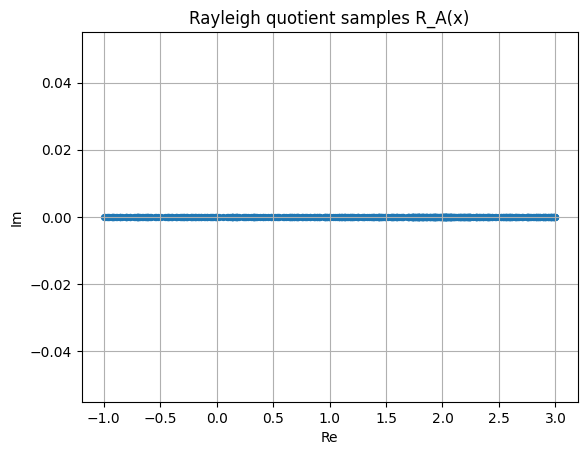

eigvals(A) = [-1.  2.  3.]
Guessed field of values interval = [-1, 3]


In [4]:
A = np.array([[1.,0.,-2.],
               [0.,2.,0.],
               [-2.,0.,1.]], float)

def rayleigh(A, x):
    x = np.asarray(x).reshape(-1, 1)
    return float((x.T @ A @ x) / (x.T @ x))

# Monte Carlo samples of R_A(x)
vals = []
for _ in range(500):
    x = rng.standard_normal(A.shape[0])
    vals.append(rayleigh(A, x))

vals = np.array(vals)

# Plot samples on the complex plane (imag part ~ 0 for symmetric A)
plt.figure()
plt.scatter(vals.real, np.zeros_like(vals), s=18)
plt.xlabel("Re")
plt.ylabel("Im")
plt.title("Rayleigh quotient samples R_A(x)")
plt.grid(True)
plt.show()

evals = np.linalg.eigvalsh(A)
print("eigvals(A) =", evals)
print("Guessed field of values interval = [{:.6g}, {:.6g}]".format(evals.min(), evals.max()))


**Conclusion**  
Samples lie on the real axis between the smallest and largest eigenvalues. With eigenvalues \(\{-1, 2, 3\}\), the field of values is the interval **\([-1,\,3]\)**.


## Exercise 7 — Timing: general vs symmetric eigenvalue solvers

We compare `np.linalg.eigvals(A)` (general dense) vs `np.linalg.eigvalsh(S)` (symmetric/Hermitian) on random matrices of size \(n\).
> Tip: Adjust the size grid if your machine is slow.


{'n': 800, 'time_general_s': 0.3377251000000001, 'time_symmetric_s': 0.061197500000000016, 'speedup': 5.518609420319458}


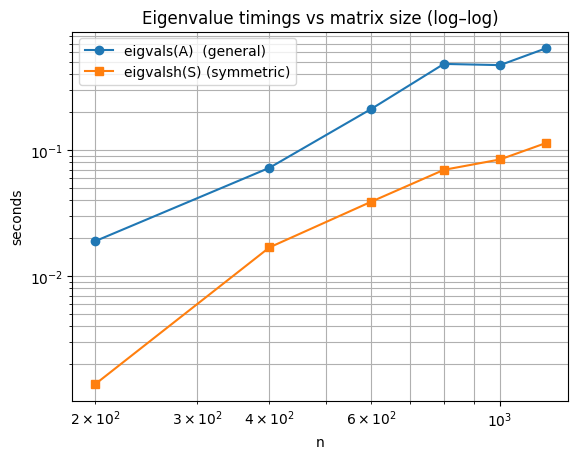

n= 200 : general=0.0189s   symmetric=0.00138s   speedup≈13.68x
n= 400 : general=0.0724s   symmetric=0.0169s   speedup≈4.29x
n= 600 : general=0.213s   symmetric=0.039s   speedup≈5.46x
n= 800 : general=0.484s   symmetric=0.0697s   speedup≈6.94x
n=1000 : general=0.473s   symmetric=0.0843s   speedup≈5.61x
n=1200 : general=0.643s   symmetric=0.114s   speedup≈5.65x


In [5]:
def time_eigs(n, repeats=2, seed=123):
    rng_local = np.random.default_rng(seed)
    A = rng_local.standard_normal((n, n))
    S = A + A.T  # symmetric
    t_gen = []
    t_sym = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = np.linalg.eigvals(A)      # general
        t1 = time.perf_counter()
        _ = np.linalg.eigvalsh(S)     # symmetric/Hermitian
        t2 = time.perf_counter()
        t_gen.append(t1 - t0)
        t_sym.append(t2 - t1)
    return float(min(t_gen)), float(min(t_sym))

# (a) Single size
n0 = 800
tg, ts = time_eigs(n0, repeats=1, seed=7)
print({'n': n0, 'time_general_s': tg, 'time_symmetric_s': ts, 'speedup': tg/ts})

# (b) Sweep
ns = list(range(200, 1300, 200))  # 200,400,...,1200
times_g = []
times_s = []
for n in ns:
    tg, ts = time_eigs(n, repeats=1, seed=42+n)
    times_g.append(tg)
    times_s.append(ts)

plt.figure()
plt.loglog(ns, times_g, marker='o', label='eigvals(A)  (general)')
plt.loglog(ns, times_s, marker='s', label='eigvalsh(S) (symmetric)')
plt.xlabel('n')
plt.ylabel('seconds')
plt.title('Eigenvalue timings vs matrix size (log–log)')
plt.legend()
plt.grid(True, which='both')
plt.show()

for n, tg, ts in zip(ns, times_g, times_s):
    print(f"n={n:4d} : general={tg:.3g}s   symmetric={ts:.3g}s   speedup≈{tg/ts:.2f}x")


---

### Repro notes
- Figures use Matplotlib’s defaults; no explicit colors or styles are set.
- Each figure uses a single plot (no subplots).
- Randomness is controlled by a fixed `rng` seed for repeatability.
